In [ ]:
https://learnopencv.com/fine-tuning-trocr-training-trocr-to-recognize-curved-text/

: 

Finetuning Tutorial für TrOCR

In [1]:

%pip install -q transformers
%pip install -q sentencepiece
%pip install -q jiwer
%pip install -q datasets
%pip install -q evaluate
%pip install -q -U accelerate
 
 
%pip install -q matplotlib
%pip install -q protobuf==3.20.1
%pip install -q tensorboard

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
 
 
from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

c:\Users\paulp\miniconda3\envs\opticalFlow\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
 
seed_everything(42)
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")
 
 
    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)
 
 
    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])
 
 
        print("Done")
 
 
    except Exception as e:
        print("\nInvalid file.", e)
 
 
URL = r"https://www.dropbox.com/scl/fi/vyvr7jbdvu8o174mbqgde/scut_data.zip?rlkey=fs8axkpxunwu6if9a2su71kxs&dl=1"
asset_zip_path = os.path.join(os.getcwd(), "scut_data.zip")
 
# Download if asset ZIP does not exist.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

In [5]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 48
    EPOCHS:        int = 35
    LEARNING_RATE: float = 0.00005
 
@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = 'scut_data'
 
@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-printed'

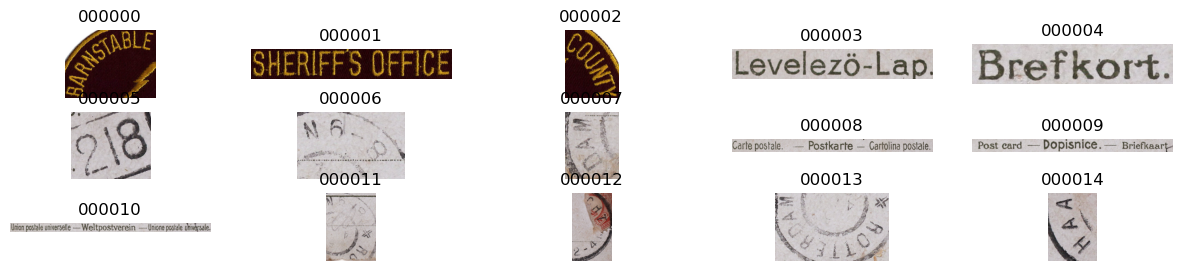

In [6]:
def visualize(dataset_path):
    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        all_images = os.listdir(f"{dataset_path}/scut_train")
        image = plt.imread(f"{dataset_path}/scut_train/{all_images[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.title(all_images[i].split('.')[0])
    plt.show()
 
 
visualize(DatasetConfig.DATA_ROOT)

In [7]:
train_df = pd.read_fwf(
    os.path.join(DatasetConfig.DATA_ROOT, 'scut_train.txt'), header=None
)
train_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)
test_df = pd.read_fwf(
    os.path.join(DatasetConfig.DATA_ROOT, 'scut_test.txt'), header=None
)
test_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)

In [8]:
# Augmentations.
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

In [9]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
 
 
    def __len__(self):
        return len(self.df)
 
 
    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['file_name'][idx]
        # The text (label).
        text = self.df['text'][idx]
        # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(self.root_dir + file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [10]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'scut_train/'),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'scut_test/'),
    df=test_df,
    processor=processor
)

The image processor of type `DeiTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


In [11]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Loading weights: 100%|██████████| 360/360 [00:00<00:00, 1357.11it/s, Materializing param=encoder.layernorm.weight]                                     
VisionEncoderDecoderModel LOAD REPORT from: microsoft/trocr-small-printed
Key                         | Status  | 
----------------------------+---------+-
encoder.pooler.dense.bias   | MISSING | 
encoder.pooler.dense.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
        

In [12]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

In [18]:
import evaluate

cer_metric = evaluate.load("cer")
def compute_cer(eval_pred):
    preds, labels = eval_pred

    tok = processor.tokenizer
    pad_id = tok.pad_token_id

    # preds can be tuple in some setups
    if isinstance(preds, (tuple, list)):
        preds = preds[0]

    # If preds are logits (rare with predict_with_generate=True), argmax them
    if preds.ndim == 3:
        preds = np.argmax(preds, axis=-1)

    # Replace ignore index in labels before decoding
    labels = np.where(labels == -100, pad_id, labels)

    # Ensure valid integer dtype for the tokenizer
    preds = preds.astype(np.int64)
    labels = labels.astype(np.int64)

    pred_str = tok.batch_decode(preds, skip_special_tokens=True)
    label_str = tok.batch_decode(labels, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return {"cer": cer}

In [14]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="seq2seq_model_printed/",

    predict_with_generate=True,
    generation_max_length=64,
    label_names=["labels"],

    eval_strategy="epoch",      # <-- NEU in v5
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=5,

    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    num_train_epochs=TrainingConfig.EPOCHS,

    fp16=True,
    report_to="tensorboard",
)

In [27]:
import numpy as np
import evaluate

cer_metric = evaluate.load("cer")

def compute_cer(pred):
    tok = processor.tokenizer
    pad_id = tok.pad_token_id

    labels_ids = pred.label_ids
    print (labels_ids)
    pred_ids = pred.predictions

    # pred_ids can be tuple/list depending on HF internals
    if isinstance(pred_ids, (tuple, list)):
        pred_ids = pred_ids[0]

    # If logits: [batch, seq, vocab] -> ids
    if hasattr(pred_ids, "ndim") and pred_ids.ndim == 3:
        pred_ids = np.argmax(pred_ids, axis=-1)

    # Make copies and ensure integer dtype
    labels_ids = np.array(labels_ids, dtype=np.int64, copy=True)
    pred_ids   = np.array(pred_ids,   dtype=np.int64, copy=True)

    # Replace ignore index before decoding (critical)
    labels_ids[labels_ids == -100] = pad_id

    # Safety: remove any remaining negatives (shouldn't happen, but prevents OverflowError)
    pred_ids[pred_ids < 0] = pad_id

    pred_str  = tok.batch_decode(pred_ids,   skip_special_tokens=True)
    label_str = tok.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return {"cer": cer}



In [15]:
import accelerate, transformers
print("transformers", transformers.__version__)
print("accelerate", accelerate.__version__)

transformers 5.1.0
accelerate 1.12.0


In [ ]:

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.sep_token_id

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_cer,
    processing_class=processor,
    data_collator=default_data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Cer
1,1.086826,2.052223,0.582755
2,1.146343,2.006627,0.576280
3,1.027584,2.000353,0.559388
4,0.926312,2.021648,0.567863
5,0.846439,2.065843,0.586816
6,0.821312,2.002666,0.615362
7,0.754674,2.059337,0.596233
8,0.694482,1.995872,0.564097
9,0.625529,2.097777,0.560212
10,0.587072,2.065749,0.577634


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


[[    0 22644 10091 ...  -100  -100  -100]
 [    0 15980    27 ...  -100  -100  -100]
 [    0  7259  2673 ...  -100  -100  -100]
 ...
 [    0 10587  5429 ...  -100  -100  -100]
 [    0  9896 24276 ...  -100  -100  -100]
 [    0 56796  1969 ...  -100  -100  -100]]


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


TrainOutput(global_step=4445, training_loss=0.3911726335840901, metrics={'train_runtime': 10125.042, 'train_samples_per_second': 20.92, 'train_steps_per_second': 0.439, 'total_flos': 2.5338901289175613e+19, 'train_loss': 0.3911726335840901, 'epoch': 35.0})

In [30]:
import torch

@torch.inference_mode()
def ocr_one(image, processor, model, device, max_new_tokens=64):
    model.eval()
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    gen_ids = model.generate(
        pixel_values,
        max_new_tokens=max_new_tokens,
        # optional, falls nötig:
        # pad_token_id=processor.tokenizer.pad_token_id,
        # eos_token_id=processor.tokenizer.eos_token_id,
    )
    text = processor.tokenizer.batch_decode(gen_ids, skip_special_tokens=True)[0]
    return text

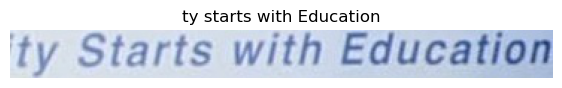

FILE: 006052.jpg
PRED: ty starts with Education
--------------------------------------------------------------------------------


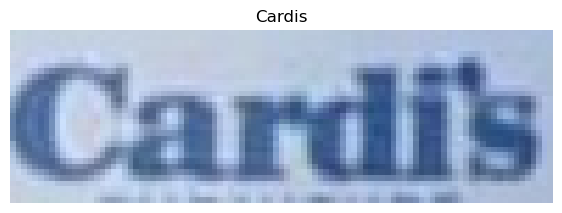

FILE: 006053.jpg
PRED: Cardis
--------------------------------------------------------------------------------


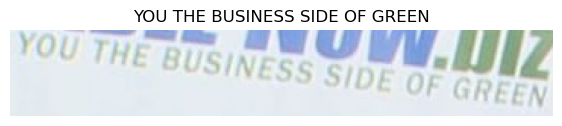

FILE: 006054.jpg
PRED: YOU THE BUSINESS SIDE OF GREEN
--------------------------------------------------------------------------------


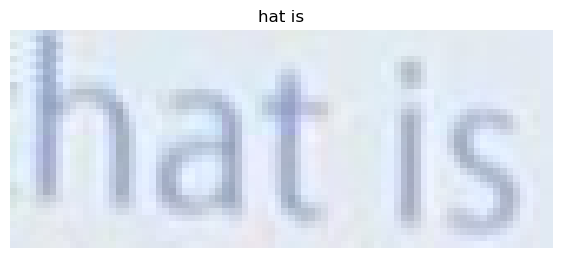

FILE: 006055.jpg
PRED: hat is
--------------------------------------------------------------------------------


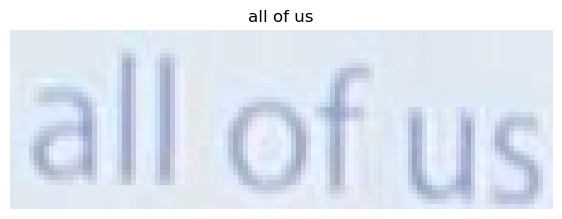

FILE: 006056.jpg
PRED: all of us
--------------------------------------------------------------------------------


In [35]:
# ===== INFERENCE TEST (AFTER TRAINING) =====

import os
import glob
import torch
import matplotlib.pyplot as plt
from PIL import Image

tok = processor.tokenizer
model.eval()
model.to(device)

model.config.decoder_start_token_id = tok.bos_token_id
model.config.pad_token_id = tok.pad_token_id
model.config.eos_token_id = tok.eos_token_id

model.generation_config.decoder_start_token_id = tok.bos_token_id
model.generation_config.pad_token_id = tok.pad_token_id
model.generation_config.eos_token_id = tok.eos_token_id


@torch.inference_mode()
def ocr_image(image):
    pixel_values = processor(
        images=image,
        return_tensors="pt"
    ).pixel_values.to(device)

    generated_ids = model.generate(
        pixel_values,
        max_new_tokens=64,
        num_beams=1,
        do_sample=False
    )

    text = tok.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )[0]
    return text


def run_inference(
    image_glob=os.path.join(DatasetConfig.DATA_ROOT, "scut_test", "*"),
    num_samples=5
):
    paths = sorted(glob.glob(image_glob))[:num_samples]

    for p in paths:
        image = Image.open(p).convert("RGB")
        text = ocr_image(image)

        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis("off")
        plt.show()

        print("FILE:", os.path.basename(p))
        print("PRED:", text)
        print("-" * 80)


run_inference(num_samples=5)

In [36]:
from transformers import VisionEncoderDecoderModel, AutoProcessor

model = VisionEncoderDecoderModel.from_pretrained("ocr_final_model").to(device)
processor = AutoProcessor.from_pretrained("ocr_final_model")

model.eval()

OSError: ocr_final_model is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

Exception ignored in: <function tqdm.__del__ at 0x00000258B2255440>
Traceback (most recent call last):
  File "c:\Users\paulp\miniconda3\envs\opticalFlow\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\paulp\miniconda3\envs\opticalFlow\Lib\site-packages\tqdm\notebook.py", line 277, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
